In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/home/bharaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [6]:
### READ DATA ###

df = pd.read_csv('bbc-text.csv')

print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [7]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [8]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [13]:
listk=df['category'].tolist()
import numpy as np
np.unique(listk,return_counts=True)

(array(['business', 'entertainment', 'politics', 'sport', 'tech'],
       dtype='<U13'), array([510, 386, 417, 511, 401]))

In [9]:
### SPLIT INTO TRAIN/TEST ###

y = np_utils.to_categorical(df.category.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [10]:
print(X_train[0],y[0])

['eurovision', 'greats', 'to', 'do', 'battle', 'stars', 'of', 'the', 'eurovision', 'song', 'contest', 'from', 'the', 'show', 's', 'year', 'history', 'are', 'to', 'compete', 'against', 'each', 'other', 'to', 'celebrate', 'the', 'contest', 's', 'anniversary', 'viewers', 'will', 'choose', 'past', 'songs', 'to', 'be', 'performed', 'by', 'the', 'original', 'artists', 'or', 'others', 'in', 'the', 'spirit', 'of', 'the', 'originals', 'past', 'eurovision', 'performers', 'include', 'abba', 'celine', 'dion', 'bucks', 'fizz', 'nana', 'mouskouri', 'lulu', 'and', 'julio', 'iglesias', 'fans', 'will', 'then', 'vote', 'as', 'usual', 'to', 'pick', 'the', 'all', 'time', 'best', 'eurovision', 'song', 'during', 'the', 'show', 'in', 'denmark', 'in', 'october', 'the', 'first', 'contest', 'was', 'organised', 'by', 'the', 'european', 'broadcasting', 'union', 'or', 'ebu', 'in', 'and', 'has', 'become', 'an', 'annual', 'event', 'pitting', 'pop', 'giants', 'against', 'musical', 'minnows', 'with', 'often', 'surpris

In [9]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [10]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [11]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(1780, 200) (445, 200)


In [12]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 14539


In [13]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [14]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [15]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

W0108 15:02:44.450825 140398920136448 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 15:02:44.475261 140398920136448 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 15:02:44.480072 140398920136448 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0108 15:02:44.492686 140398920136448 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2537000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2537000     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [16]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [17]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

W0108 15:02:47.879395 140398920136448 deprecation.py:506] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0108 15:02:48.406217 140398920136448 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     2537000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     2537000     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 

In [18]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

W0108 15:02:48.655665 140398920136448 deprecation.py:323] From /home/bharaj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1602 samples, validate on 178 samples
Epoch 1/20
 - 18s - loss: 1.4884 - acc: 0.3583 - val_loss: 1.3223 - val_acc: 0.4494
Epoch 2/20
 - 15s - loss: 1.2449 - acc: 0.5156 - val_loss: 1.1686 - val_acc: 0.5169
Epoch 3/20
 - 15s - loss: 1.0945 - acc: 0.5774 - val_loss: 1.0889 - val_acc: 0.5449
Epoch 4/20
 - 15s - loss: 0.9405 - acc: 0.6330 - val_loss: 0.9168 - val_acc: 0.6573
Epoch 5/20
 - 15s - loss: 0.8191 - acc: 0.7016 - val_loss: 0.7330 - val_acc: 0.7528
Epoch 6/20
 - 15s - loss: 0.6945 - acc: 0.7640 - val_loss: 0.8581 - val_acc: 0.7303
Epoch 7/20
 - 15s - loss: 0.6477 - acc: 0.7834 - val_loss: 0.5507 - val_acc: 0.8146
Epoch 8/20
 - 15s - loss: 0.6451 - acc: 0.7865 - val_loss: 1.3000 - val_acc: 0.5787
Epoch 9/20
 - 15s - loss: 0.8276 - acc: 0.7197 - val_loss: 0.7184 - val_acc: 0.7584
Epoch 10/20
 - 14s - loss: 0.6802 - acc: 0.7603 - val_loss: 0.5707 - val_acc: 0.7753
Epoch 11/20
 - 14s - loss: 0.5536 - acc: 0.8140 - val_loss: 0.4672 - val_acc: 0.8596
Epoch 12/20
 - 14s - loss: 

In [19]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.90      0.98      0.94        90
entertainment       0.91      0.76      0.83        88
     politics       0.86      0.95      0.90        73
        sport       0.94      0.95      0.95       106
         tech       0.93      0.91      0.92        88

    micro avg       0.91      0.91      0.91       445
    macro avg       0.91      0.91      0.91       445
 weighted avg       0.91      0.91      0.91       445



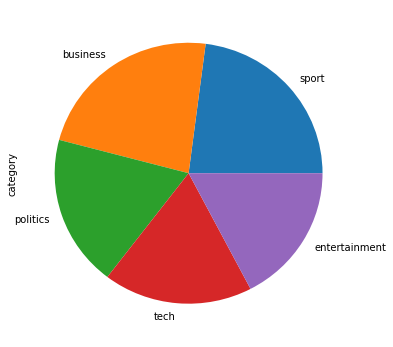

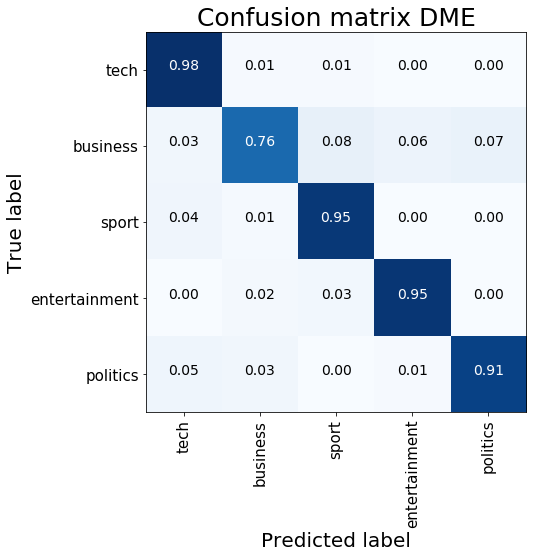

In [20]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [ ]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     2537000     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 100)     2537000     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 

In [ ]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/20
 - 23s - loss: 1.5030 - acc: 0.3446 - val_loss: 1.3474 - val_acc: 0.4551
Epoch 2/20
 - 17s - loss: 1.2526 - acc: 0.4950 - val_loss: 1.2299 - val_acc: 0.4888
Epoch 3/20
 - 18s - loss: 1.1147 - acc: 0.5630 - val_loss: 1.1098 - val_acc: 0.5562
Epoch 4/20
 - 18s - loss: 0.9772 - acc: 0.6273 - val_loss: 1.0010 - val_acc: 0.5955
Epoch 5/20
 - 18s - loss: 0.8596 - acc: 0.6760 - val_loss: 0.8389 - val_acc: 0.6629
Epoch 6/20
 - 18s - loss: 0.7166 - acc: 0.7447 - val_loss: 0.6340 - val_acc: 0.7921
Epoch 7/20
 - 18s - loss: 0.6902 - acc: 0.7715 - val_loss: 0.6253 - val_acc: 0.7753
Epoch 8/20
 - 18s - loss: 0.6595 - acc: 0.7896 - val_loss: 0.5881 - val_acc: 0.7978
Epoch 9/20
 - 18s - loss: 0.5200 - acc: 0.8240 - val_loss: 0.4581 - val_acc: 0.8539
Epoch 10/20
 - 18s - loss: 0.4858 - acc: 0.8483 - val_loss: 0.4021 - val_acc: 0.8596
Epoch 11/20
 - 18s - loss: 0.4015 - acc: 0.8727 - val_loss: 0.3428 - val_acc: 0.8652
Epoch 12/20
 - 18s - loss: 

In [ ]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

In [ ]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()